In [1]:
import os, sys, pybamm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
solver = pybamm.CasadiSolver(
    mode="safe",
    rtol=1e-5,  # 상대 허용 오차 증가 → Solver가 더 유연해짐
    atol=1e-5,  # 절대 허용 오차 증가 → Solver가 작은 수치 변화에 덜 민감해짐
    root_method="hybr",  # 초기 조건 찾기 알고리즘을 SciPy의 "hybr"로 변경
    root_tol=1e-5,  # 루트 허용 오차 증가
    max_step_decrease_count=10,  # 스텝 크기 감소 허용 횟수를 증가시켜 Solver가 더 많은 시도 가능
    dt_max=100,  # 최대 시간 스텝을 100초로 줄여 수치적 안정성 증가
    extrap_tol=1e-6,  # 외삽 허용 오차 추가
    extra_options_setup={"max_num_steps": 100000, "print_stats": False},  # CasADi 설정 변경
    return_solution_if_failed_early=True,  # Solver가 실패해도 일부 결과 반환
    perturb_algebraic_initial_conditions=False,  # 초기 조건의 작은 교란 비활성화
    integrators_maxcount=200,  # 통합기 개수 증가 (메모리 사용 증가 가능)
)

In [3]:
# SPM, SPMe, DFN 제공
# 그외 MPM, MSMR 제공
spm = pybamm.lithium_ion.SPM()
spm.default_parameter_values.search('Nominal cell capacity [A.h]')
spm.default_parameter_values.search('Upper voltage cut-off [V]')
spm.default_parameter_values.search('Lower voltage cut-off [V]')
spm.default_parameter_values.search('Current function [A]')

Nominal cell capacity [A.h]	0.680616
Upper voltage cut-off [V]	4.1
Lower voltage cut-off [V]	3.105
Current function [A]	0.680616


Text(0.5, 1.0, 'Voltage [V]')

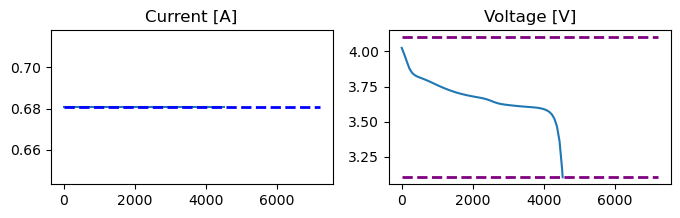

In [44]:
# simulation 정의
# solver를 통해 해 도출
sim = pybamm.Simulation(spm)
sol = sim.solve([0, 7200], initial_soc=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
ax1.plot(sol['Time [s]'].entries, sol['Current [A]'].entries)
ax1.hlines(y=0.680616, xmin=0, xmax=7200, colors='b', linestyles='--', lw=2); ax1.set_title('Current [A]')
ax2.plot(sol['Time [s]'].entries, sol['Voltage [V]'].entries)
ax2.hlines(y=[4.1, 3.105], xmin=0, xmax=7200, colors='purple', linestyles='--', lw=2); ax2.set_title('Voltage [V]')

Text(0.5, 1.0, 'Voltage [V]')

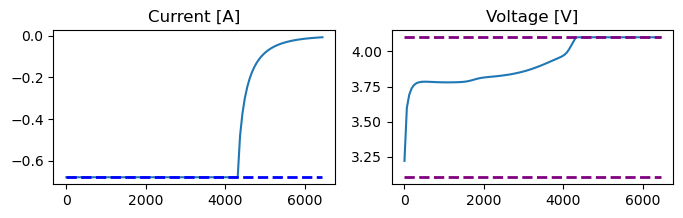

In [45]:
# 완전 충전
full_charge = pybamm.Experiment(
    [ ("Charge at 1 C until 4.1 V", "Hold at 4.1 V until C/100",) ],
    )

sim = pybamm.Simulation(spm, experiment=full_charge)
sol = sim.solve(initial_soc=0); t = sol['Time [s]'].entries; i = sol['Current [A]'].entries; v = sol['Voltage [V]'].entries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
ax1.plot(t, i); ax1.hlines(y=-0.680616, xmin=t[0], xmax=t[-1], colors='b', linestyles='--', lw=2); ax1.set_title('Current [A]')
ax2.plot(t, v); ax2.hlines(y=[4.1, 3.105], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=2); ax2.set_title('Voltage [V]')

Text(0.5, 1.0, 'Voltage [V]')

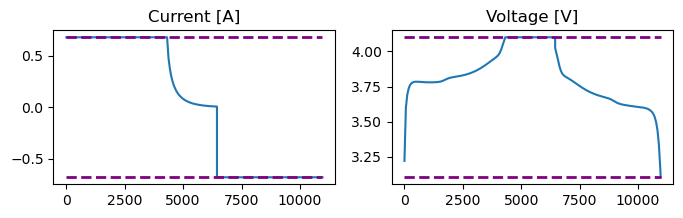

In [49]:
# 완전 충전 후 방전
full_charge_discharge = pybamm.Experiment(
    [ ("Charge at 1 C until 4.1 V", "Hold at 4.1 V until C/100",) ] +
    [ ("Discharge at 1 C until 3.105 V",) ],
    )

sim = pybamm.Simulation(spm, experiment=full_charge_discharge)
sol = sim.solve(initial_soc=0); t = sol['Time [s]'].entries; i = -sol['Current [A]'].entries; v = sol['Voltage [V]'].entries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
ax1.plot(t, i); ax1.hlines(y=[-0.680616, 0.680616], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=2); ax1.set_title('Current [A]')
ax2.plot(t, v); ax2.hlines(y=[4.1, 3.105], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=2); ax2.set_title('Voltage [V]')

Text(0.5, 1.0, 'Cell temperature [C]')

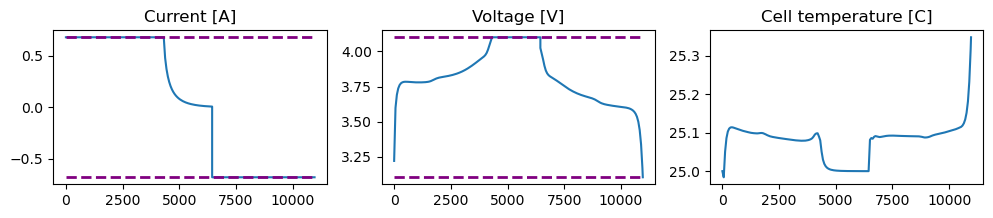

In [52]:
# 완전 충전 후 방전 시, lumped model로 온도까지 고려 
spm_wT = pybamm.lithium_ion.SPM(options={'thermal': 'lumped'})
sim_wT = pybamm.Simulation(spm_wT, experiment=full_charge_discharge)
sol_wT = sim_wT.solve(initial_soc=0); 
t_wT = sol_wT['Time [s]'].entries; i_wT = -sol_wT['Current [A]'].entries; v_wT = sol_wT['Voltage [V]'].entries; T = sol_wT['Cell temperature [C]'].entries[0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, i_wT); ax1.hlines(y=[-0.680616, 0.680616], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=2); ax1.set_title('Current [A]')
ax2.plot(t_wT, v_wT); ax2.hlines(y=[4.1, 3.105], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=2); ax2.set_title('Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title('Cell temperature [C]')

In [6]:
# 배터리 완전 충방전 1000 cycle
ageing_cycle = pybamm.Experiment(
    [ ("Charge at 1 C until 4.1 V", 
       "Hold at 4.1 V until C/100", 
       "Rest for 15 minutes", 
       "Discharge at 1 C until 3.105 V", 
       "Rest for 15 minutes",) ] * 300,
    termination="80% capacity",
    )

spm_wT_cycle = pybamm.lithium_ion.SPM(options={'thermal': 'lumped'})
sim_wT_cycle = pybamm.Simulation(spm_wT_cycle, experiment=ageing_cycle, solver=solver)
sol_wT_cycle = sim_wT_cycle.solve();
print(sol_wT_cycle.solve_time)

28.966 s


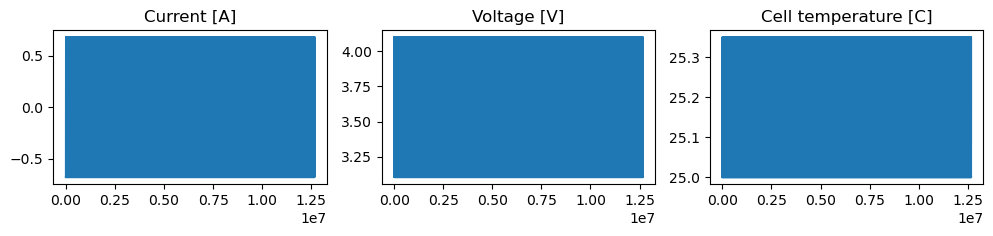

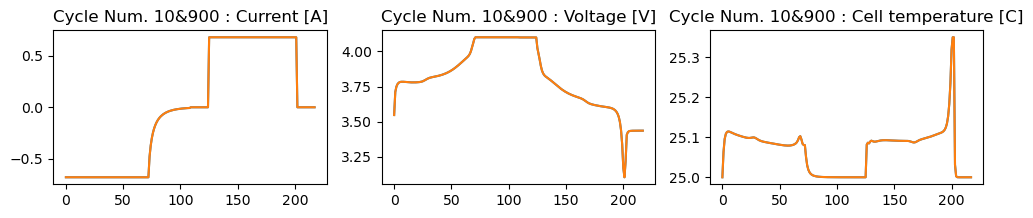

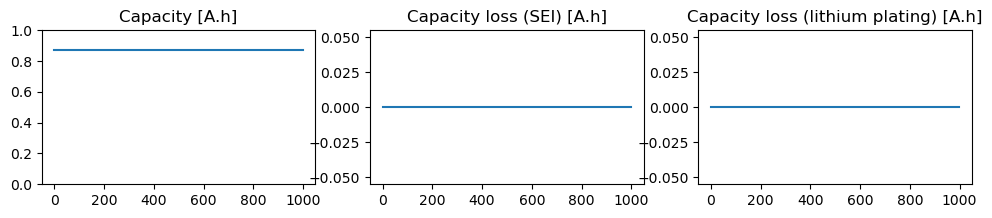

In [55]:
# 결과확인 : 노화되지 않음
t_wT = sol_wT_cycle['Time [s]'].entries; i_wT = sol_wT_cycle['Current [A]'].entries; v_wT = sol_wT_cycle['Voltage [V]'].entries; T = sol_wT_cycle['Cell temperature [C]'].entries[0]
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, i_wT); ax1.set_title('Current [A]')
ax2.plot(t_wT, v_wT); ax2.set_title('Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title('Cell temperature [C]')
plt.savefig(f'none_degrade_1.png', dpi=200)

cycle_num_1 = 10
t_wT = sol_wT_cycle.cycles[cycle_num_1]['Time [s]'].entries; i_wT = sol_wT_cycle.cycles[cycle_num_1]['Current [A]'].entries; v_wT = sol_wT_cycle.cycles[cycle_num_1]['Voltage [V]'].entries; T = sol_wT_cycle.cycles[cycle_num_1]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_wT_cycle.cycles[cycle_num_1]['Time [s]'].entries))
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}: Current [A]')
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}: Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}: Cell temperature [C]')

cycle_num_2 = 900
t_wT = sol_wT_cycle.cycles[cycle_num_2]['Time [s]'].entries; i_wT = sol_wT_cycle.cycles[cycle_num_2]['Current [A]'].entries; v_wT = sol_wT_cycle.cycles[cycle_num_2]['Voltage [V]'].entries; T = sol_wT_cycle.cycles[cycle_num_2]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_wT_cycle.cycles[cycle_num_2]['Time [s]'].entries))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Current [A]')
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Cell temperature [C]')
plt.savefig(f'none_degrade_2.png', dpi=200)

t_wT = sol_wT_cycle.summary_variables['Cycle number'];
c_wT = sol_wT_cycle.summary_variables['Capacity [A.h]'];
SEI_wT = sol_wT_cycle.summary_variables['Change in loss of capacity to negative SEI [A.h]'];
li_wT = sol_wT_cycle.summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
t_wT = range(len(sol_wT_cycle.summary_variables['Cycle number']))
fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, c_wT); ax1.set_ylim([0, 1]); ax1.set_title(f'Capacity [A.h]')
ax2.plot(t_wT, SEI_wT); ax2.set_title(f'Capacity loss (SEI) [A.h]')
ax3.plot(t_wT, li_wT); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
plt.savefig(f'none_degrade_3.png', dpi=200)

### Okane

In [4]:
# li plating 고려
Okane_ageing_cycle = pybamm.Experiment(
    [ ("Discharge at 1 C until 2.5 V", 
       "Rest for 15 minutes",
       "Charge at 1 C until 4.2 V", 
       "Hold at 4.2 V until C/100", 
       "Rest for 15 minutes", ) ] * 1000,
    termination="80% capacity",
    period="10s"
    )

# 'Exchange-current density for stripping [A.m-2]' parameter가 필요
spm_cycle_li = pybamm.lithium_ion.SPM(options={'thermal': 'lumped', "lithium plating": "partially reversible"})
param = pybamm.ParameterValues("OKane2022")
sim_cycle_li = pybamm.Simulation(spm_cycle_li, parameter_values=param, experiment=Okane_ageing_cycle, solver=solver)
sol_cycle_li = sim_cycle_li.solve(initial_soc=0.7);
param.search('Nominal cell capacity [A.h]')
param.search('Upper voltage cut-off [V]')
param.search('Lower voltage cut-off [V]')
print(sol_cycle_li.solve_time)
print(len(sol_cycle_li.cycles))

/home/hpark/anaconda3/envs/torch_base/lib/python3.9/site-packages/pybamm/models/full_battery_models/base_battery_model.py:910: OptionWarning: The 'lumped' thermal option with 'dimensionality' 0 now uses the parameters 'Cell cooling surface area [m2]', 'Cell volume [m3]' and 'Total heat transfer coefficient [W.m-2.K-1]' to compute the cell cooling term, regardless of the value of the the 'cell geometry' option. Please update your parameters accordingly.
  options = BatteryModelOptions(extra_options)


Nominal cell capacity [A.h]	5.0
Upper voltage cut-off [V]	4.2
Lower voltage cut-off [V]	2.5
1 minute, 8 seconds
1000


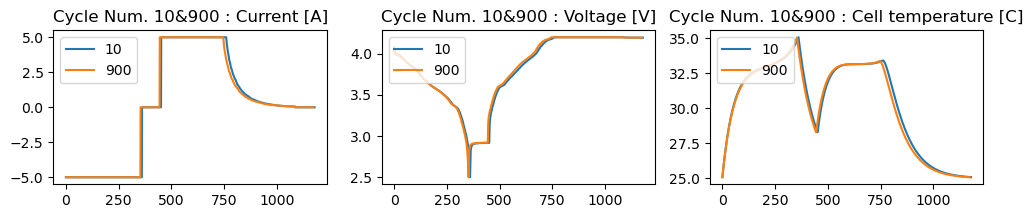

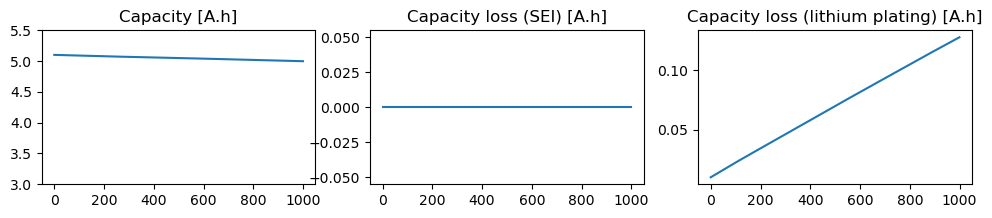

In [6]:
# 결과확인 : li plating 발생
cycle_num_1 = 10
t_wT = sol_cycle_li.cycles[cycle_num_1]['Time [s]'].entries; i_wT = -sol_cycle_li.cycles[cycle_num_1]['Current [A]'].entries; v_wT = sol_cycle_li.cycles[cycle_num_1]['Voltage [V]'].entries; T = sol_cycle_li.cycles[cycle_num_1]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_li.cycles[cycle_num_1]['Time [s]'].entries))
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}: Current [A]')
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}: Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}: Cell temperature [C]')

cycle_num_2 = 900
t_wT = sol_cycle_li.cycles[cycle_num_2]['Time [s]'].entries; i_wT = -sol_cycle_li.cycles[cycle_num_2]['Current [A]'].entries; v_wT = sol_cycle_li.cycles[cycle_num_2]['Voltage [V]'].entries; T = sol_cycle_li.cycles[cycle_num_2]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_li.cycles[cycle_num_2]['Time [s]'].entries))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Current [A]'); ax1.legend(["10", "900"], loc="upper left")
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Voltage [V]'); ax2.legend(["10", "900"], loc="upper left")
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Cell temperature [C]'); ax3.legend(["10", "900"], loc="upper left")
plt.savefig(f'LiP_10_900.png', dpi=200)

t_wT = sol_cycle_li.summary_variables['Cycle number'];
c_wT = sol_cycle_li.summary_variables['Capacity [A.h]'];
dSEI = sol_cycle_li.summary_variables['Change in loss of capacity to negative SEI [A.h]']
dli = sol_cycle_li.summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
SEI_wT = np.cumsum(dSEI); li_wT = np.cumsum(dli)
t_wT = range(len(sol_cycle_li.summary_variables['Cycle number']))
fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, c_wT); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
ax2.plot(t_wT, SEI_wT); ax2.set_title(f'Capacity loss (SEI) [A.h]')
ax3.plot(t_wT, li_wT); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
plt.savefig(f'LiP_summary.png', dpi=200)

In [7]:
# SEI growth 고려
Okane_ageing_cycle = pybamm.Experiment(
    [ ("Discharge at 1 C until 2.5 V", 
       "Rest for 15 minutes",
       "Charge at 1 C until 4.2 V", 
       "Hold at 4.2 V until C/100", 
       "Rest for 15 minutes", ) ] * 1000,
    termination="80% capacity",
    period="10s"
    )

# 'Negative electrode initial crack length [m]' parameter가 필요
spm_cycle_SEI = pybamm.lithium_ion.SPMe(options={'thermal': 'lumped', "SEI": "solvent-diffusion limited"})
param = pybamm.ParameterValues("OKane2022")
sim_cycle_SEI = pybamm.Simulation(spm_cycle_SEI, parameter_values=param, experiment=Okane_ageing_cycle, solver=solver)
sol_cycle_SEI = sim_cycle_SEI.solve(initial_soc=0.7);
param.search('Nominal cell capacity [A.h]')
param.search('Upper voltage cut-off [V]')
param.search('Lower voltage cut-off [V]')
print(sol_cycle_SEI.solve_time)
print(len(sol_cycle_li.cycles))

Nominal cell capacity [A.h]	5.0
Upper voltage cut-off [V]	4.2
Lower voltage cut-off [V]	2.5
22 minutes, 1 second
1000


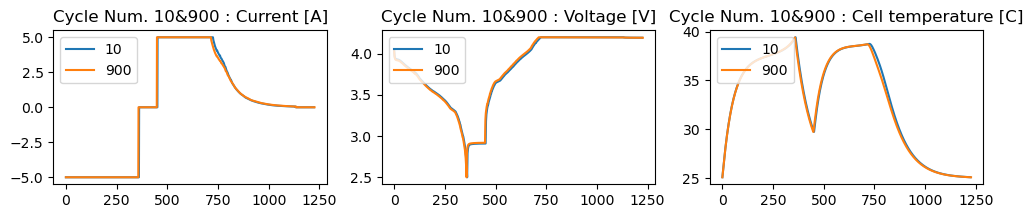

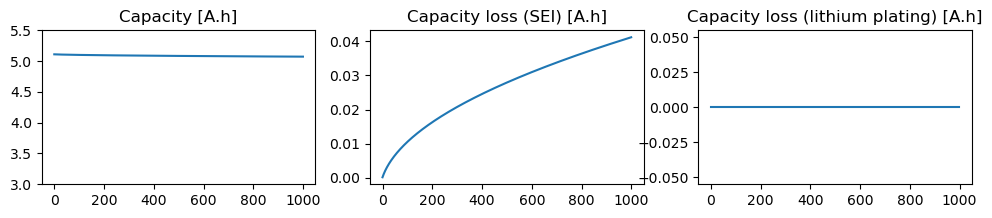

In [8]:
# 결과확인 : SEI growth 발생
# 'Zero negative electrode porosity cut-off' is occured when "SEI porosity change": "true" at cycle 321
cycle_num_1 = 10
t_wT = sol_cycle_SEI.cycles[cycle_num_1]['Time [s]'].entries; i_wT = -sol_cycle_SEI.cycles[cycle_num_1]['Current [A]'].entries; v_wT = sol_cycle_SEI.cycles[cycle_num_1]['Voltage [V]'].entries; T = sol_cycle_SEI.cycles[cycle_num_1]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_SEI.cycles[cycle_num_1]['Time [s]'].entries))
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}: Current [A]')
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}: Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}: Cell temperature [C]')

cycle_num_2 = 900
t_wT = sol_cycle_SEI.cycles[cycle_num_2]['Time [s]'].entries; i_wT = -sol_cycle_SEI.cycles[cycle_num_2]['Current [A]'].entries; v_wT = sol_cycle_SEI.cycles[cycle_num_2]['Voltage [V]'].entries; T = sol_cycle_SEI.cycles[cycle_num_2]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_SEI.cycles[cycle_num_2]['Time [s]'].entries))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Current [A]'); ax1.legend(["10", "900"], loc="upper left")
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Voltage [V]'); ax2.legend(["10", "900"], loc="upper left")
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Cell temperature [C]'); ax3.legend(["10", "900"], loc="upper left")
plt.savefig(f'SEI_10_900.png', dpi=200)

t_wT = sol_cycle_SEI.summary_variables['Cycle number'];
c_wT = sol_cycle_SEI.summary_variables['Capacity [A.h]'];
dSEI = sol_cycle_SEI.summary_variables['Change in loss of capacity to negative SEI [A.h]']
dli = sol_cycle_SEI.summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
SEI_wT = np.cumsum(dSEI); li_wT = np.cumsum(dli)
t_wT = range(len(sol_cycle_SEI.summary_variables['Cycle number']))
fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, c_wT); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
ax2.plot(t_wT, SEI_wT); ax2.set_title(f'Capacity loss (SEI) [A.h]')
ax3.plot(t_wT, li_wT); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
plt.savefig(f'SEI_summary.png', dpi=200)

In [17]:
# LAM은 이상함
# 둘 다 고려
# SPM으로 동작 시, "repeated recoverable right-hand side function errors."
# The electrolyte will deplete. 
# For the DFN, this means it will stop when the electrolyte gets close to zero (hence it will stop before reaching the 2.5V cut-off). 
# For the SPM, the simulations should run (once the dt_max is reduced) 
# but the results will make no physical sense as they do not include any electrolyte effect.
Okane_ageing_cycle = pybamm.Experiment(
    [ ("Discharge at 1 C until 2.5 V", 
       "Rest for 15 minutes",
       "Charge at 1 C until 4.2 V", 
       "Hold at 4.2 V until C/100", 
       "Rest for 15 minutes", ) ] * 1000,
    termination="80% capacity",
    period="30s"
    )

spm_cycle_aging = pybamm.lithium_ion.SPMe(options={'thermal': 'lumped', "lithium plating": "irreversible",})
param = pybamm.ParameterValues("OKane2022")
sim_cycle_aging = pybamm.Simulation(spm_cycle_aging, parameter_values=param, experiment=Okane_ageing_cycle, solver=solver)
sol_cycle_aging = sim_cycle_aging.solve(initial_soc=0.7);
param.search('Nominal cell capacity [A.h]')
param.search('Upper voltage cut-off [V]')
param.search('Lower voltage cut-off [V]')
print(sol_cycle_aging.solve_time)
print(len(sol_cycle_aging.cycles))

Nominal cell capacity [A.h]	5.0
Upper voltage cut-off [V]	4.2
Lower voltage cut-off [V]	2.5
11.088 s
14


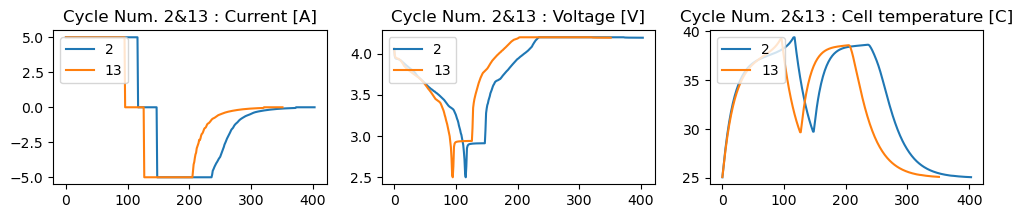

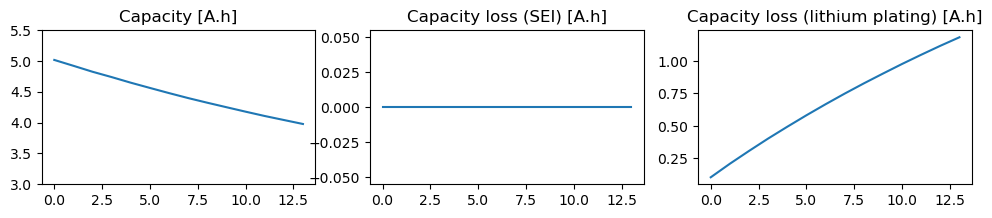

In [18]:
# 결과확인 : 전부 발생
cycle_num_1 = 2
t_wT = sol_cycle_aging.cycles[cycle_num_1]['Time [s]'].entries; i_wT = sol_cycle_aging.cycles[cycle_num_1]['Current [A]'].entries; v_wT = sol_cycle_aging.cycles[cycle_num_1]['Voltage [V]'].entries; T = sol_cycle_aging.cycles[cycle_num_1]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_aging.cycles[cycle_num_1]['Time [s]'].entries))
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}: Current [A]')
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}: Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}: Cell temperature [C]')

cycle_num_2 = 13
t_wT = sol_cycle_aging.cycles[cycle_num_2]['Time [s]'].entries; i_wT = sol_cycle_aging.cycles[cycle_num_2]['Current [A]'].entries; v_wT = sol_cycle_aging.cycles[cycle_num_2]['Voltage [V]'].entries; T = sol_cycle_aging.cycles[cycle_num_2]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_aging.cycles[cycle_num_2]['Time [s]'].entries))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Current [A]'); ax1.legend(["2", "13"], loc="upper left")
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Voltage [V]'); ax2.legend(["2", "13"], loc="upper left")
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Cell temperature [C]'); ax3.legend(["2", "13"], loc="upper left")
plt.savefig(f'Okane_ageing_cycle_spme_2_13.png', dpi=200)

t_wT = sol_cycle_aging.summary_variables['Cycle number'];
c_wT = sol_cycle_aging.summary_variables['Capacity [A.h]'];
dSEI = sol_cycle_aging.summary_variables['Change in loss of capacity to negative SEI [A.h]']
dli = sol_cycle_aging.summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
SEI_wT = np.cumsum(dSEI); li_wT = np.cumsum(dli)
t_wT = range(len(sol_cycle_aging.summary_variables['Cycle number']))
fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, c_wT); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
ax2.plot(t_wT, SEI_wT); ax2.set_title(f'Capacity loss (SEI) [A.h]')
ax3.plot(t_wT, li_wT); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
plt.savefig(f'Okane_ageing_cycle_spme_summary_variables.png', dpi=200)

In [24]:
Okane_high_ageing_cycle = pybamm.Experiment(
    [ ("Discharge at 1 C until 2.5 V", 
       "Rest for 15 minutes",
       "Charge at 4 C until 4.2 V", 
       "Hold at 4.2 V until C/100", 
       "Rest for 15 minutes", ) ] * 1000,
    termination="80% capacity",
    period="30s"
    )

# DFN
DFN_cycle_3C = pybamm.lithium_ion.DFN(options={'thermal': 'lumped', "lithium plating": "irreversible"})

param = pybamm.ParameterValues("OKane2022")
sim_cycle_dfn = pybamm.Simulation(DFN_cycle_3C, parameter_values=param, experiment=Okane_high_ageing_cycle, solver=solver)
sol_cycle_dfn = sim_cycle_dfn.solve(initial_soc=0.7);
print(sol_cycle_dfn.solve_time)
print(len(sol_cycle_dfn.cycles))

4 minutes, 51 seconds
25


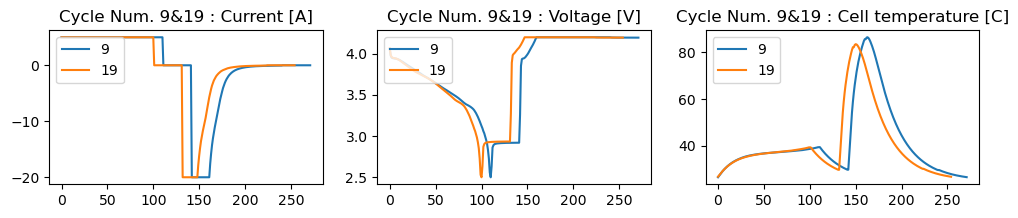

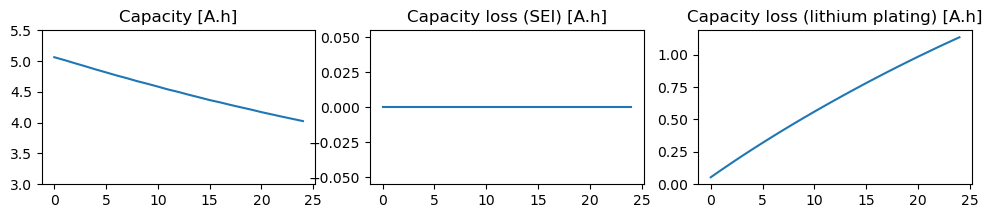

In [25]:
# 결과확인
cycle_num_1 = 9
t_wT = sol_cycle_dfn.cycles[cycle_num_1]['Time [s]'].entries; i_wT = sol_cycle_dfn.cycles[cycle_num_1]['Current [A]'].entries; v_wT = sol_cycle_dfn.cycles[cycle_num_1]['Voltage [V]'].entries; T = sol_cycle_dfn.cycles[cycle_num_1]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_dfn.cycles[cycle_num_1]['Time [s]'].entries))
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}: Current [A]')
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}: Voltage [V]')
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}: Cell temperature [C]')

cycle_num_2 = 19
t_wT = sol_cycle_dfn.cycles[cycle_num_2]['Time [s]'].entries; i_wT = sol_cycle_dfn.cycles[cycle_num_2]['Current [A]'].entries; v_wT = sol_cycle_dfn.cycles[cycle_num_2]['Voltage [V]'].entries; T = sol_cycle_dfn.cycles[cycle_num_2]['Cell temperature [C]'].entries[0]
t_wT = range(len(sol_cycle_dfn.cycles[cycle_num_2]['Time [s]'].entries))
ax1.plot(t_wT, i_wT); ax1.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Current [A]'); ax1.legend(["9", "19"], loc="upper left")
ax2.plot(t_wT, v_wT); ax2.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Voltage [V]'); ax2.legend(["9", "19"], loc="upper left")
ax3.plot(t_wT, T); ax3.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Cell temperature [C]'); ax3.legend(["9", "19"], loc="upper left")
plt.savefig(f'Okane_high_ageing_cycle_spme3c_9_19.png', dpi=200)

t_wT = sol_cycle_dfn.summary_variables['Cycle number'];
c_wT = sol_cycle_dfn.summary_variables['Capacity [A.h]'];
dSEI = sol_cycle_dfn.summary_variables['Change in loss of capacity to negative SEI [A.h]']
dli = sol_cycle_dfn.summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
SEI_wT = np.cumsum(dSEI); li_wT = np.cumsum(dli)
t_wT = range(len(sol_cycle_dfn.summary_variables['Cycle number']))
fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t_wT, c_wT); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
ax2.plot(t_wT, SEI_wT); ax2.set_title(f'Capacity loss (SEI) [A.h]')
ax3.plot(t_wT, li_wT); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
plt.savefig(f'Okane_high_ageing_cycle_spme3c_summary_variables.png', dpi=200)

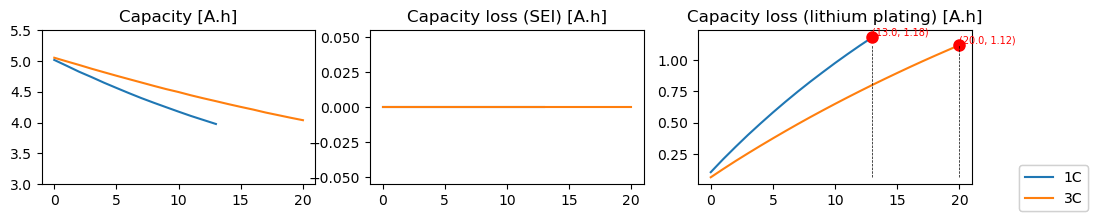

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
for name in ["sol_cycle_aging", "sol_cycle_dfn"]:
    t = globals()[f'{name}'].summary_variables['Cycle number']
    t = range(len(globals()[f'{name}'].summary_variables['Cycle number']))
    c = globals()[f'{name}'].summary_variables['Capacity [A.h]']
    dSEI = globals()[f'{name}'].summary_variables['Change in loss of capacity to negative SEI [A.h]']
    dli = globals()[f'{name}'].summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
    SEI = np.cumsum(dSEI); li = np.cumsum(dli)
    desired_t = t[-1]; SEI_at_desired_t = SEI[-1]; li_at_desired_t = li[-1]
    
    ax1.plot(t, c); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
    ax2.plot(t, SEI); ax2.set_title(f'Capacity loss (SEI) [A.h]')
    ax3.plot(t, li); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
    ax3.plot(desired_t, li_at_desired_t, 'ro', markersize=8)
    ax3.text(desired_t, li_at_desired_t, f"({desired_t:.1f}, {li_at_desired_t:.2f})", color='red', fontsize=7, verticalalignment='bottom')
    fig.legend(["1C", "3C"], loc="lower right")
xs = [13, 20]
ax3.vlines(x=xs, ymin=min(li), ymax=max(li), color='black', linestyle='--', lw=0.5)
plt.savefig(f'comp_summary.png', dpi=200)